# Inverse Design Stiffness

Libraries import.

In [1]:
import torch
import numpy as np
from LattyMorph.morphing.configs import create_flat_2D_config
from LattyMorph.morphing.lattice_models import Toti2D
from LattyMorph.fem.tools import experiment_design
from LattyMorph.fem.mapping import DifferentiableLattice
from LattyMorph.fem.mapping import precursor
from LattyMorph.fem.solving import FEModel
from LattyMorph.fem.tools import get_Yprop
from copy import deepcopy
import matplotlib.pyplot as plt
import json

Use class `Toti2D` to create a totimorphic lattice. In `Toti2D` the coordinates are encoded via the angles of the totimorphic lattice. `Toti2D` is effectively a pytorch model and the angles are trainable parameters.

In [2]:
N = 4
M = 4
target = -0.5

# initialize pytorch model 
flat_2D_sheet_config = create_flat_2D_config(N,M)
model2D = Toti2D(flat_2D_sheet_config)

# indicate constrained nodes vector
def constraint_bottom_nodes(model):
    for i in range(len(model.config[0])):
        model.config[0][i]['phi'].requires_grad = False
    model.origin.requires_grad = False
constraint_bottom_nodes(model2D)

To run finite element analysis we need to extract the node coordinates, and the mapping between rods, nodes and springs. This is done with class `fea_precursor`, which takes as arguments:
- `lattice_properties`, including the rods cross sections and Young Modules (if these are lists, each beam can have different properties, if these are scalars, the lattice is considered uniform).
- `model2D`, trainable pytorch model. 

In [3]:
# # add some noise to initialization. Helpful in some cases.

# np.random.seed(123123)
# for params in model2D.parameters():
#     params.data += np.random.normal(0,1)*1e-2
# for params in model2D.parameters():
#     print(params.data)

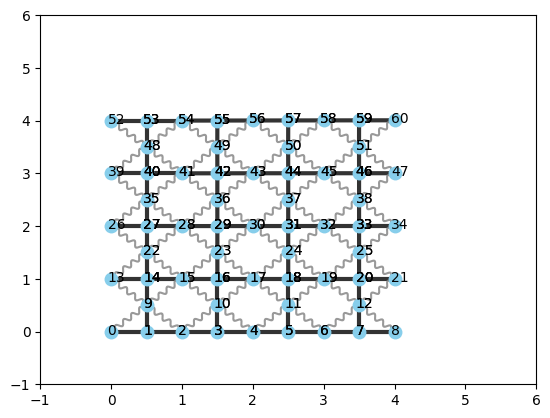

In [3]:
# assign trivial beam cross section and young module, equal for all the beams
beamCrossSection_A = torch.tensor([4e-2])
beamYoungModule_E = torch.tensor([1*1e9])
lattice_properties = { "beam_cross_section": beamCrossSection_A, "beam_young_module": beamYoungModule_E }

# initialize the fea precursor and compile the node and beam/rods dictionary
precursor2D = precursor(model2D, lattice_properties)
precursor2D.forward() # this initializes the pytorch model
precursor2D.initialize() # this implements the mapping
precursor2D.plot() 

The class `experiment_design` is used to prepare the `lattice_setup` and the `experiment_setup`, two dictionaries which inform the `dgl lattice` about the design of our problem.

In [4]:
fea_design=experiment_design( displacement=.2/5,
                                num_steps=5,
                                fit=False,
                                draw_response=False)
lattice_setup, experiment_setup = fea_design.prepare_experiment(precursor2D,"squeezing_experiment")

Indeed, these are used to produce a differentiable lattice, the object required from `get_Yprop` to get the stiffness (or effective module), the Poisson module and the displacement of the nodes. 

In [5]:
dgl_lattice = DifferentiableLattice(lattice_setup)
dgl_lattice.set_constraints(experiment_setup)

Perform direct stiffness experiment and obtain initial parameters

In [6]:
FEM_model = FEModel()
stiff, sigma_honey, delta = get_Yprop(dgl_lattice, FEM_model, experiment_setup)
original_density = float(dgl_lattice.density.detach().numpy())

print("Initial Young Module:", stiff.detach().numpy())
print("Initial Poisson Ratio:", sigma_honey.detach().numpy())
print("Initial density: ", original_density)

/home/dodo/miniforge3/envs/latty/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Initial Young Module: 202617870.0
Initial Poisson Ratio: -2.039333e-06
Initial density:  0.44946733117103577


<Axes: >

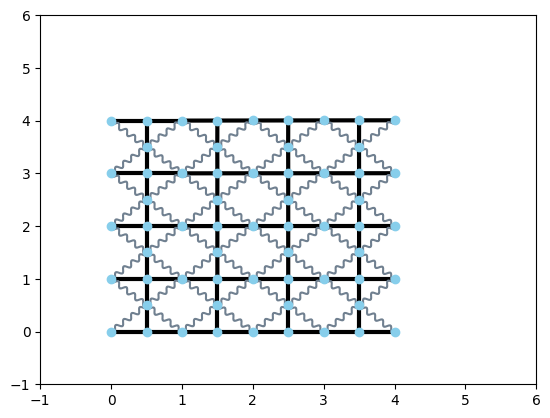

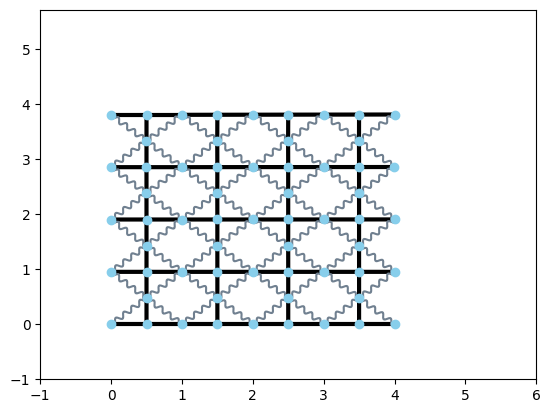

In [7]:
dgl_lattice.draw_lattice()
dgl_lattice.draw_lattice(1*delta)

Now it's time to run the optimization! The following is the classical setup for a training loop, with the only difference that the trainable parameters are the ones contained in the `model2D`.

In [8]:
# loss function and optimizer for gradient-descent based optimization
lossf = torch.nn.L1Loss()
optimizer = torch.optim.Adam(precursor2D.model2D.parameters(), lr=0.005, weight_decay = 0)

target_sigma_honey = (sigma_honey*0.+target).detach()
print("Target Poisson Ratio:", target_sigma_honey.numpy())

Target Poisson Ratio: -0.5


In [9]:
collected_sigma = [float(sigma_honey.detach().numpy())]
configs = [deepcopy(model2D.lattice_config())]

for optimization_step in range(4000):    
        
    optimizer.zero_grad()
    loss = lossf(target_sigma_honey, sigma_honey)#sigma_honey,target_sigma_honey)
    for i in range(N-1):
        loss += 0.1 * lossf(model2D.lattice[-1][i].pointAprime[1], model2D.lattice[-1][i].pointBprime[1])
        loss += 0.1 * lossf(model2D.lattice[-1][i].pointBprime[1], model2D.lattice[-1][i+1].pointBprime[1])
    loss += 0.1 * lossf(model2D.lattice[-1][-1].pointAprime[1], model2D.lattice[-1][-1].pointBprime[1])
    loss += 0.25 * lossf(model2D.lattice[-1][0].pointAprime[1], model2D.lattice[-1][-1].pointBprime[1])
    loss += 0.1 * lossf(model2D.lattice[-1][0].pointAprime[0], model2D.lattice[0][0].pointA[0])
    loss += 0.1 * lossf(model2D.lattice[-1][-1].pointBprime[0], model2D.lattice[0][-1].pointB[0])
    loss.backward()
    optimizer.step()
    
    valid = precursor2D.forward()
    if valid == False:
        print('Lattice broke!')
        break
    
    precursor2D.initialize()
    fea_design = experiment_design(displacement = 0.2/5, num_steps=5, fit=False, draw_response=False)
    experiment_kind = "squeezing_experiment"
    lattice_setup, experiment_setup = fea_design.prepare_experiment(precursor2D,experiment_kind)
    dgl_lattice = DifferentiableLattice(lattice_setup)
    stiff, sigma_honey , dr = get_Yprop(dgl_lattice, FEM_model, experiment_setup)
    collected_sigma.append(float(sigma_honey.detach().numpy()))
    configs.append(deepcopy(model2D.lattice_config()))
    if (target_sigma_honey - sigma_honey).abs() < 1e-3:
        print('Target precision reached!')
        break
    
    print("optimization step: ", optimization_step, ", loss: ", loss.detach().numpy(), ", current PR: ", sigma_honey.detach().numpy())
    

optimization step:  0 , loss:  0.50258267 , current PR:  -0.00071405445
optimization step:  1 , loss:  0.51040894 , current PR:  -0.0010502735
optimization step:  2 , loss:  0.50764525 , current PR:  -0.0012480048
optimization step:  3 , loss:  0.50558996 , current PR:  -0.0013410333
optimization step:  4 , loss:  0.5026456 , current PR:  -0.0013643263
optimization step:  5 , loss:  0.5035632 , current PR:  -0.0015711896
optimization step:  6 , loss:  0.5059609 , current PR:  -0.0018958221
optimization step:  7 , loss:  0.5032646 , current PR:  -0.0024332714
optimization step:  8 , loss:  0.5020937 , current PR:  -0.0030990147
optimization step:  9 , loss:  0.5008864 , current PR:  -0.003782064
optimization step:  10 , loss:  0.5017297 , current PR:  -0.0044736667
optimization step:  11 , loss:  0.50146335 , current PR:  -0.005191542
optimization step:  12 , loss:  0.49984902 , current PR:  -0.005901613
optimization step:  13 , loss:  0.49818492 , current PR:  -0.0066555003
optimizatio

<Axes: >

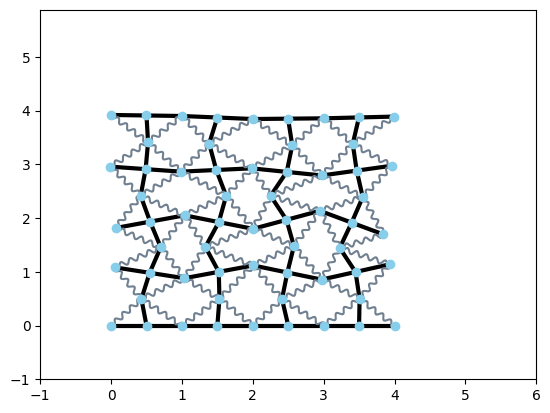

In [10]:
dgl_lattice.draw_lattice()
# plt.savefig('not_deformed.png')

<Axes: >

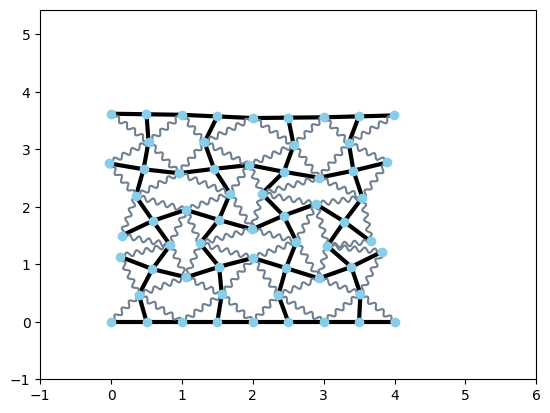

In [11]:
dgl_lattice.draw_lattice(1.5*dr)
# plt.savefig('deformed.png')

In [13]:
# results = dict()

# results['configs'] = configs
# results['final_config'] = model2D.lattice_config()
# results['dr'] = dr.detach().numpy().tolist()
# results['pr'] = collected_sigma

# with open('../../../lattymorph/Experiments/results/FEM_cm_{}x{}_{}.json'.format(N,M, target), 'w') as outfile:
#     json.dump(results, outfile)